In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import rhine_myd_func as func

In [5]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
# import functions (and packages) from R
r_time_series = robjects.r('ts')


In [6]:
SPEI_package = importr('SPEI')
r_spei_function = robjects.r['spei']

### notes

- copy time axes, because there are differences `TSpet['time'] = TSpr.time`
- first calculate reference climate

In [32]:
timescale = 21
window = 7

### Here we calculate **DAILY** integrated timeseries for the Rhine region 

In [17]:
var='pr'
freq='day'
timeslice='PD'
i='01'
j='0'
diri='/perm/nklm/Px_drought/testing/LENTIS/'

ds, ens_member = open_one_LENTIS(var, freq, timeslice, i, j, diri, plev=None)

In [18]:
dayTSpr, box_seasons = calc_boxstat(ds, 'pr', area='rhine')

In [19]:
var='pet'
freq='day'
timeslice='PD'
i='01'
j='0'
diri='/perm/nklm/Px_drought/testing/LENTIS/'

ds, ens_member = open_one_LENTIS(var, freq, timeslice, i, j, diri, plev=None)

In [20]:
dayTSpet, box_seasons = calc_boxstat(ds, 'pet_pm_asce', area='rhine')

In [21]:
r_wb_day = make_waterbalance_R(ds, dayTSpet, dayTSpr, 365)

In [22]:
SPEI_day = calc_SPEI_daily(r_wb_day, timescale)

## and SPEI3 longer droughts 

In [46]:
SPEI3 = calc_SPEI_daily(r_wb_day, 90)

### Now calculate Soil Moisture index...

In [27]:
var='mrsos'
freq='day'
timeslice='PD'
i='01'
j='0'
diri='/perm/nklm/Px_drought/testing/LENTIS/'

ds, ens_member = open_one_LENTIS(var, freq, timeslice, i, j, diri, plev=None)

tsf, box_seasons = calc_boxstat(ds, var, area='rhine')
r_tsf = r_time_series(robjects.FloatVector(ts), start = robjects.IntVector([ds.time.dt.year[0].values, ds.time.dt.month[0].values]), frequency = 365)

In [34]:

SMIF_day = calc_SPEI_daily(r_tsf, timescale)

## and total column SM index

In [29]:
var='mrso'
freq='day'
timeslice='PD'
i='01'
j='0'
diri='/perm/nklm/Px_drought/testing/LENTIS/'

ds, ens_member = open_one_LENTIS(var, freq, timeslice, i, j, diri, plev=None)

tst, box_seasons = calc_boxstat(ds, var, area='rhine')
r_tst = r_time_series(robjects.FloatVector(ts), start = robjects.IntVector([ds.time.dt.year[0].values, ds.time.dt.month[0].values]), frequency = 365)

In [30]:

SMIT_day = calc_SPEI_daily(r_tst, timescale)

In [35]:
dSPEI14_sum_7 = first_order_deriv_rolling_sum(SPEI_day,window)
dSMIF14_sum_7 = first_order_deriv_rolling_sum(SMIF_day,window)
dSMIT14_sum_7 = first_order_deriv_rolling_sum(SMIT_day,window)

da_pr_ann = calc_annual_cycle_quantiles((dayTSpr*60*60*24), [0.5,])
da_pet_ann = calc_annual_cycle_quantiles((dayTSpet), [0.5,])
da_smf_ann = calc_annual_cycle_quantiles((tsf), [0.5,])
da_smt_ann = calc_annual_cycle_quantiles((tst), [0.5,])

In [36]:

pr_rol_mean = pd.Series(dayTSpr*60*60*24).rolling(window=window).mean()
pet_rol_mean = pd.Series(dayTSpet).rolling(window=window).mean()

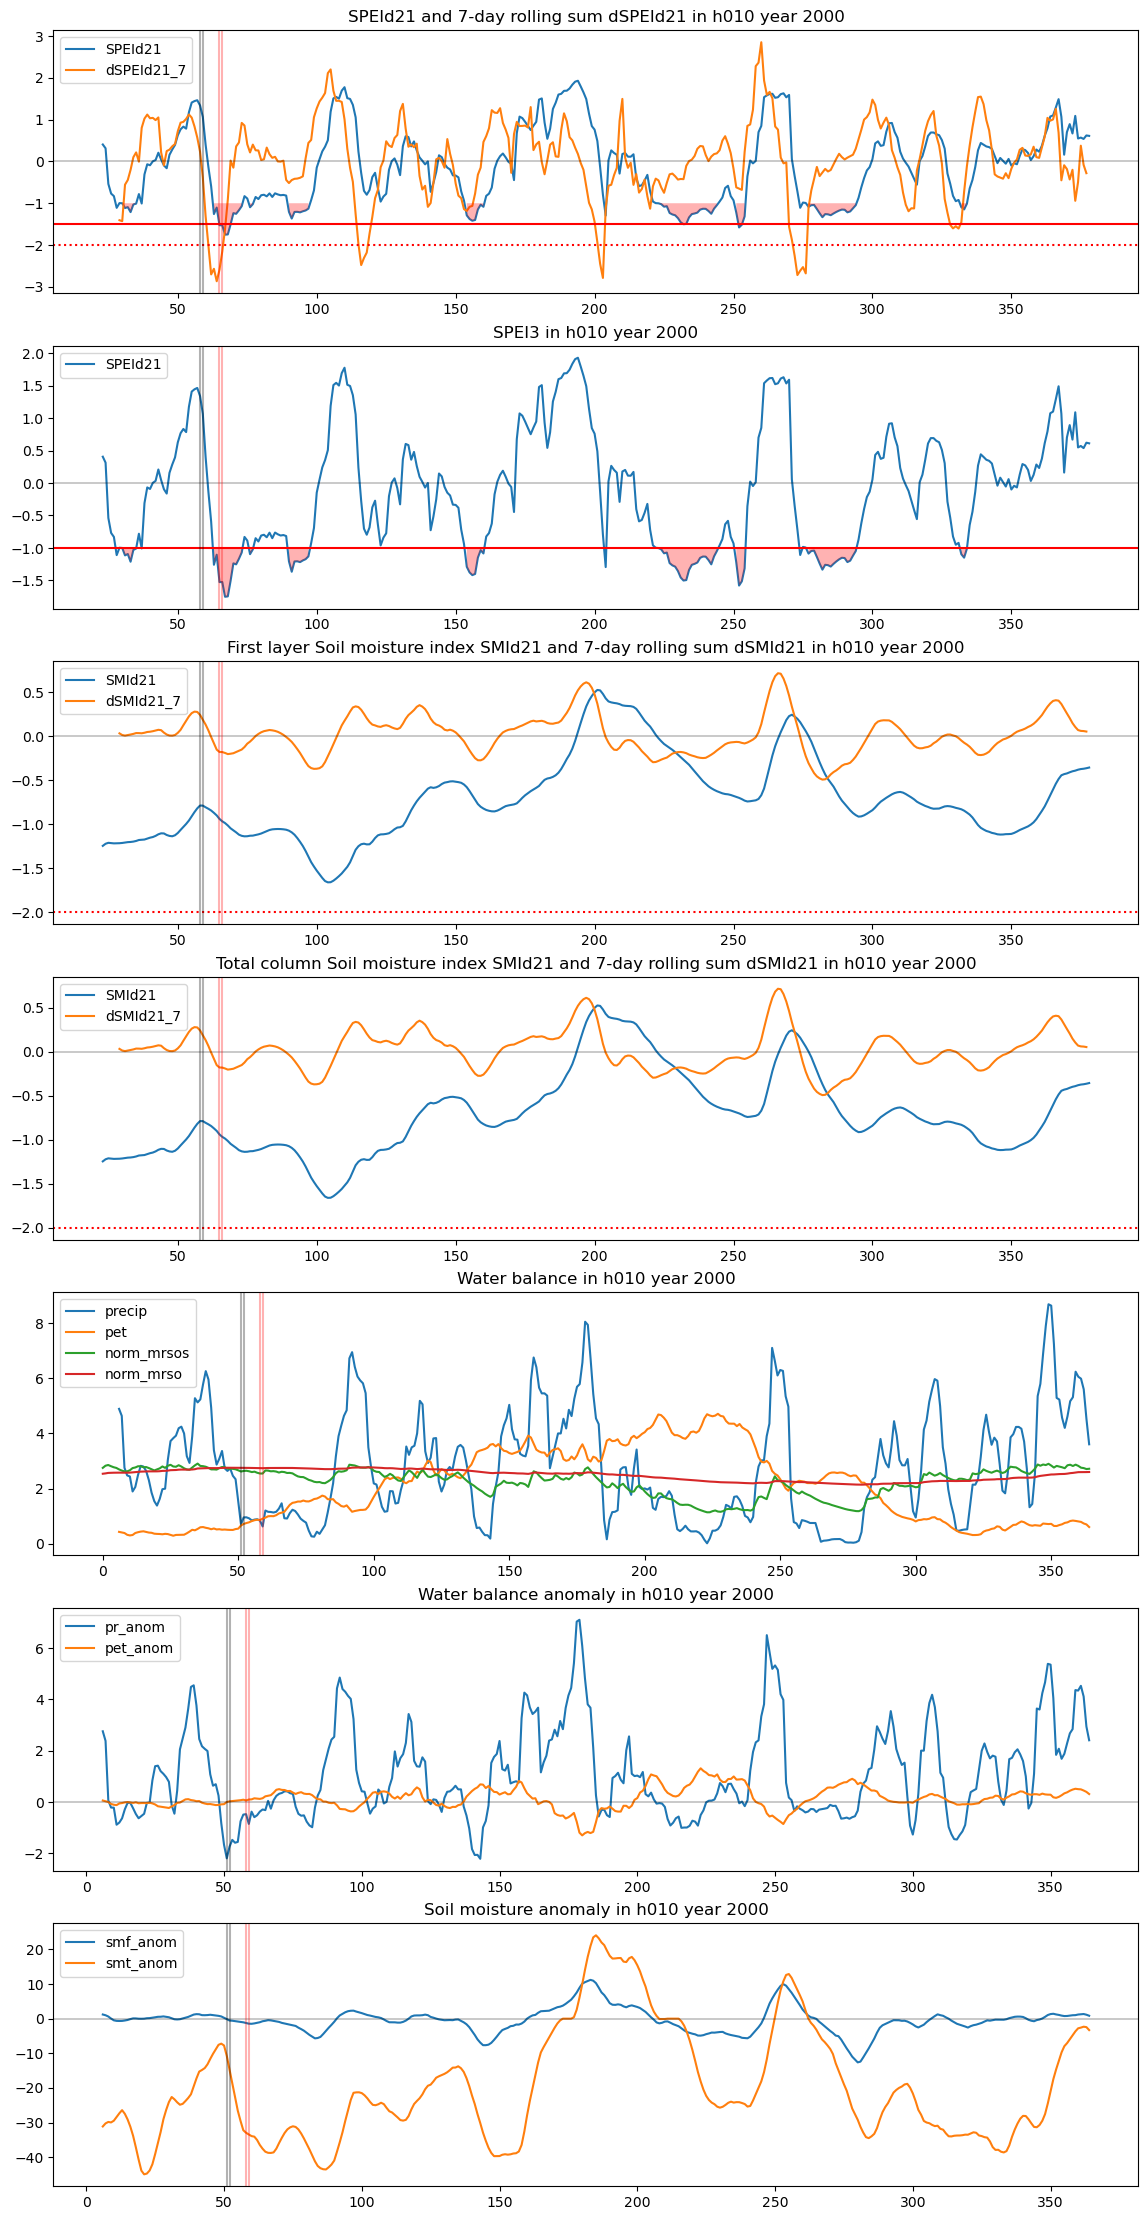

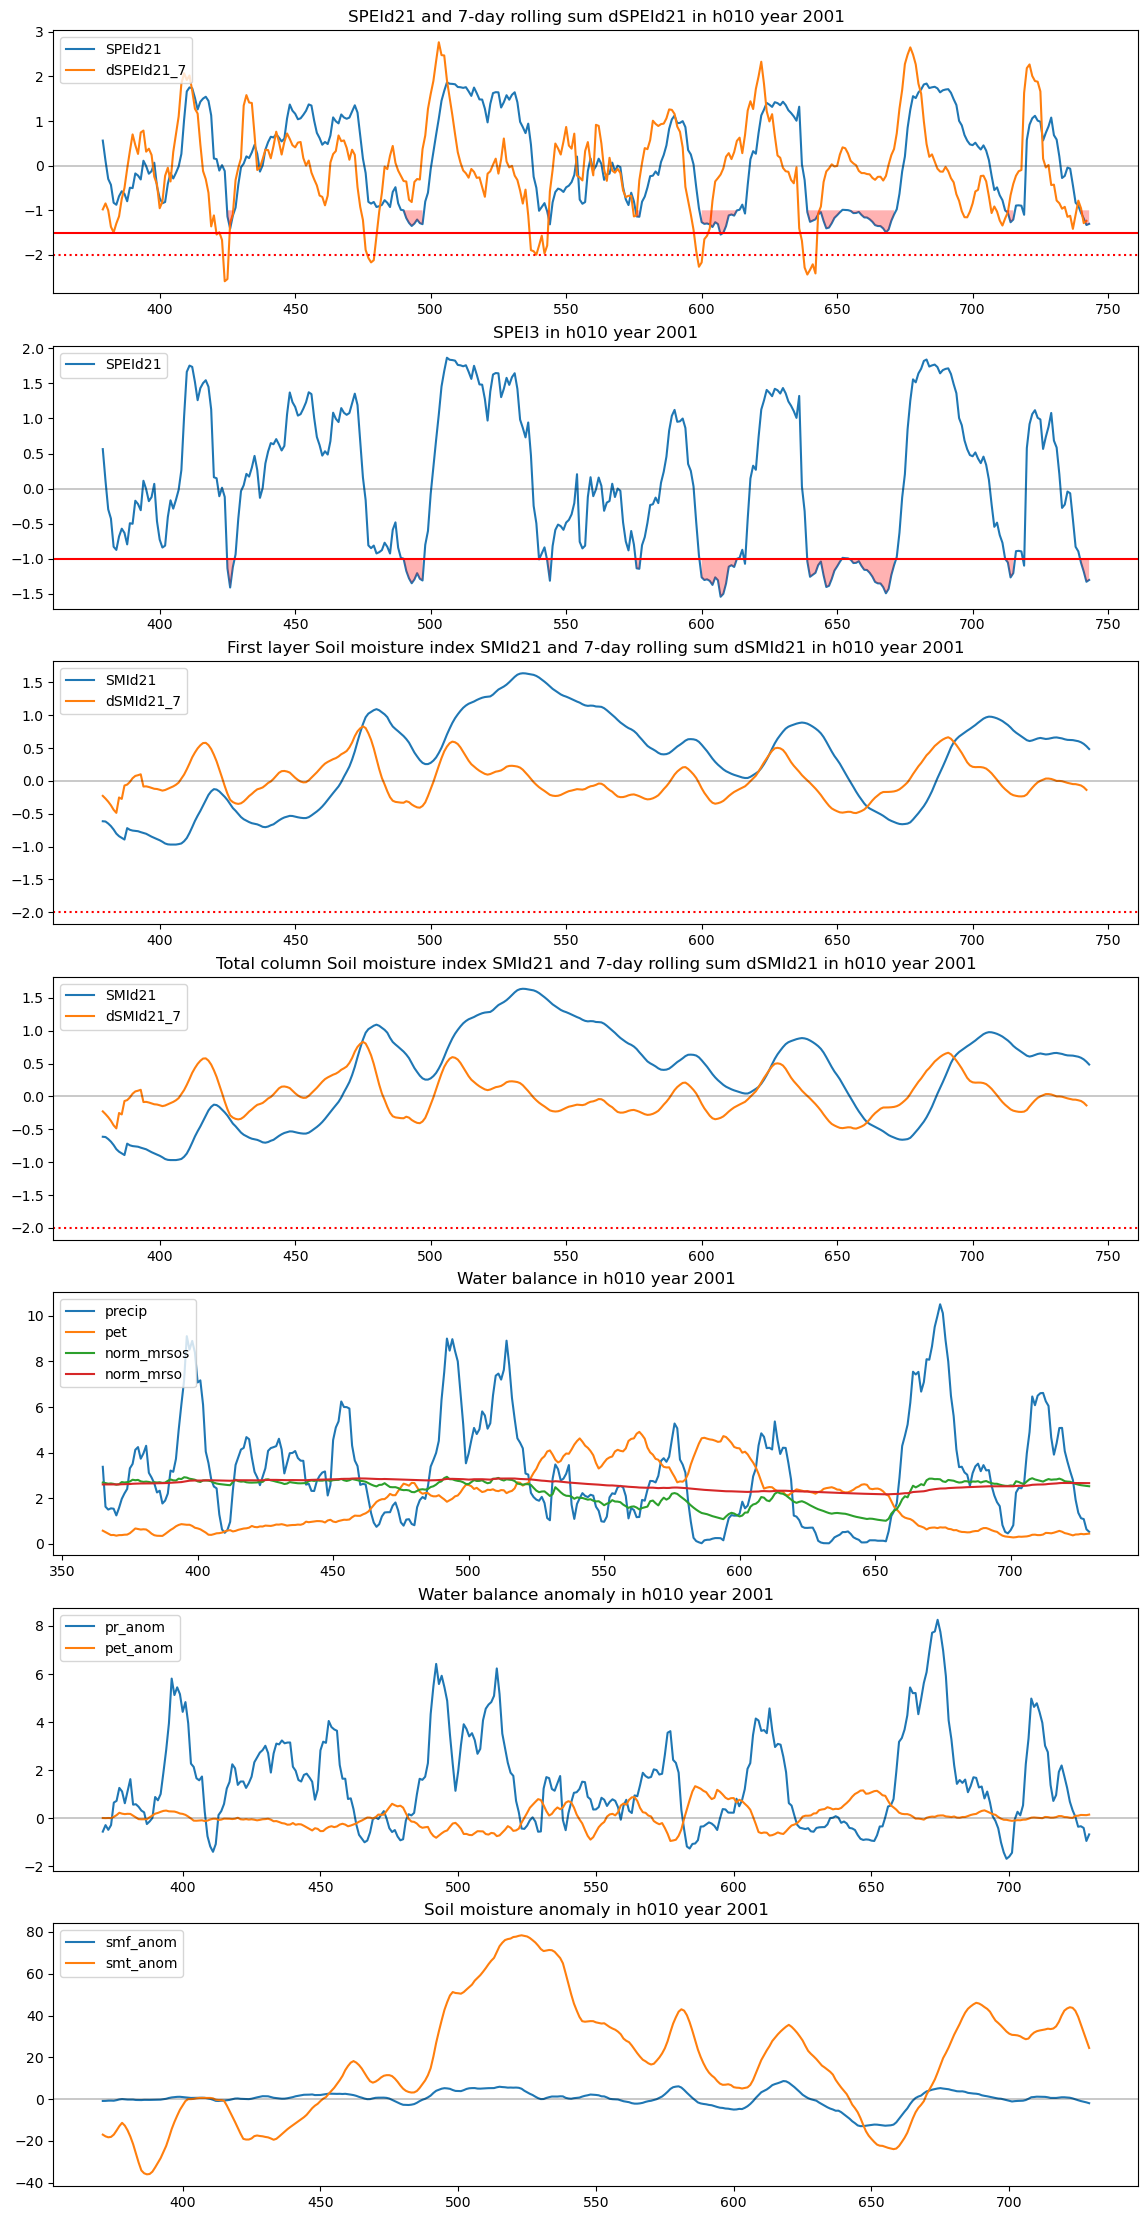

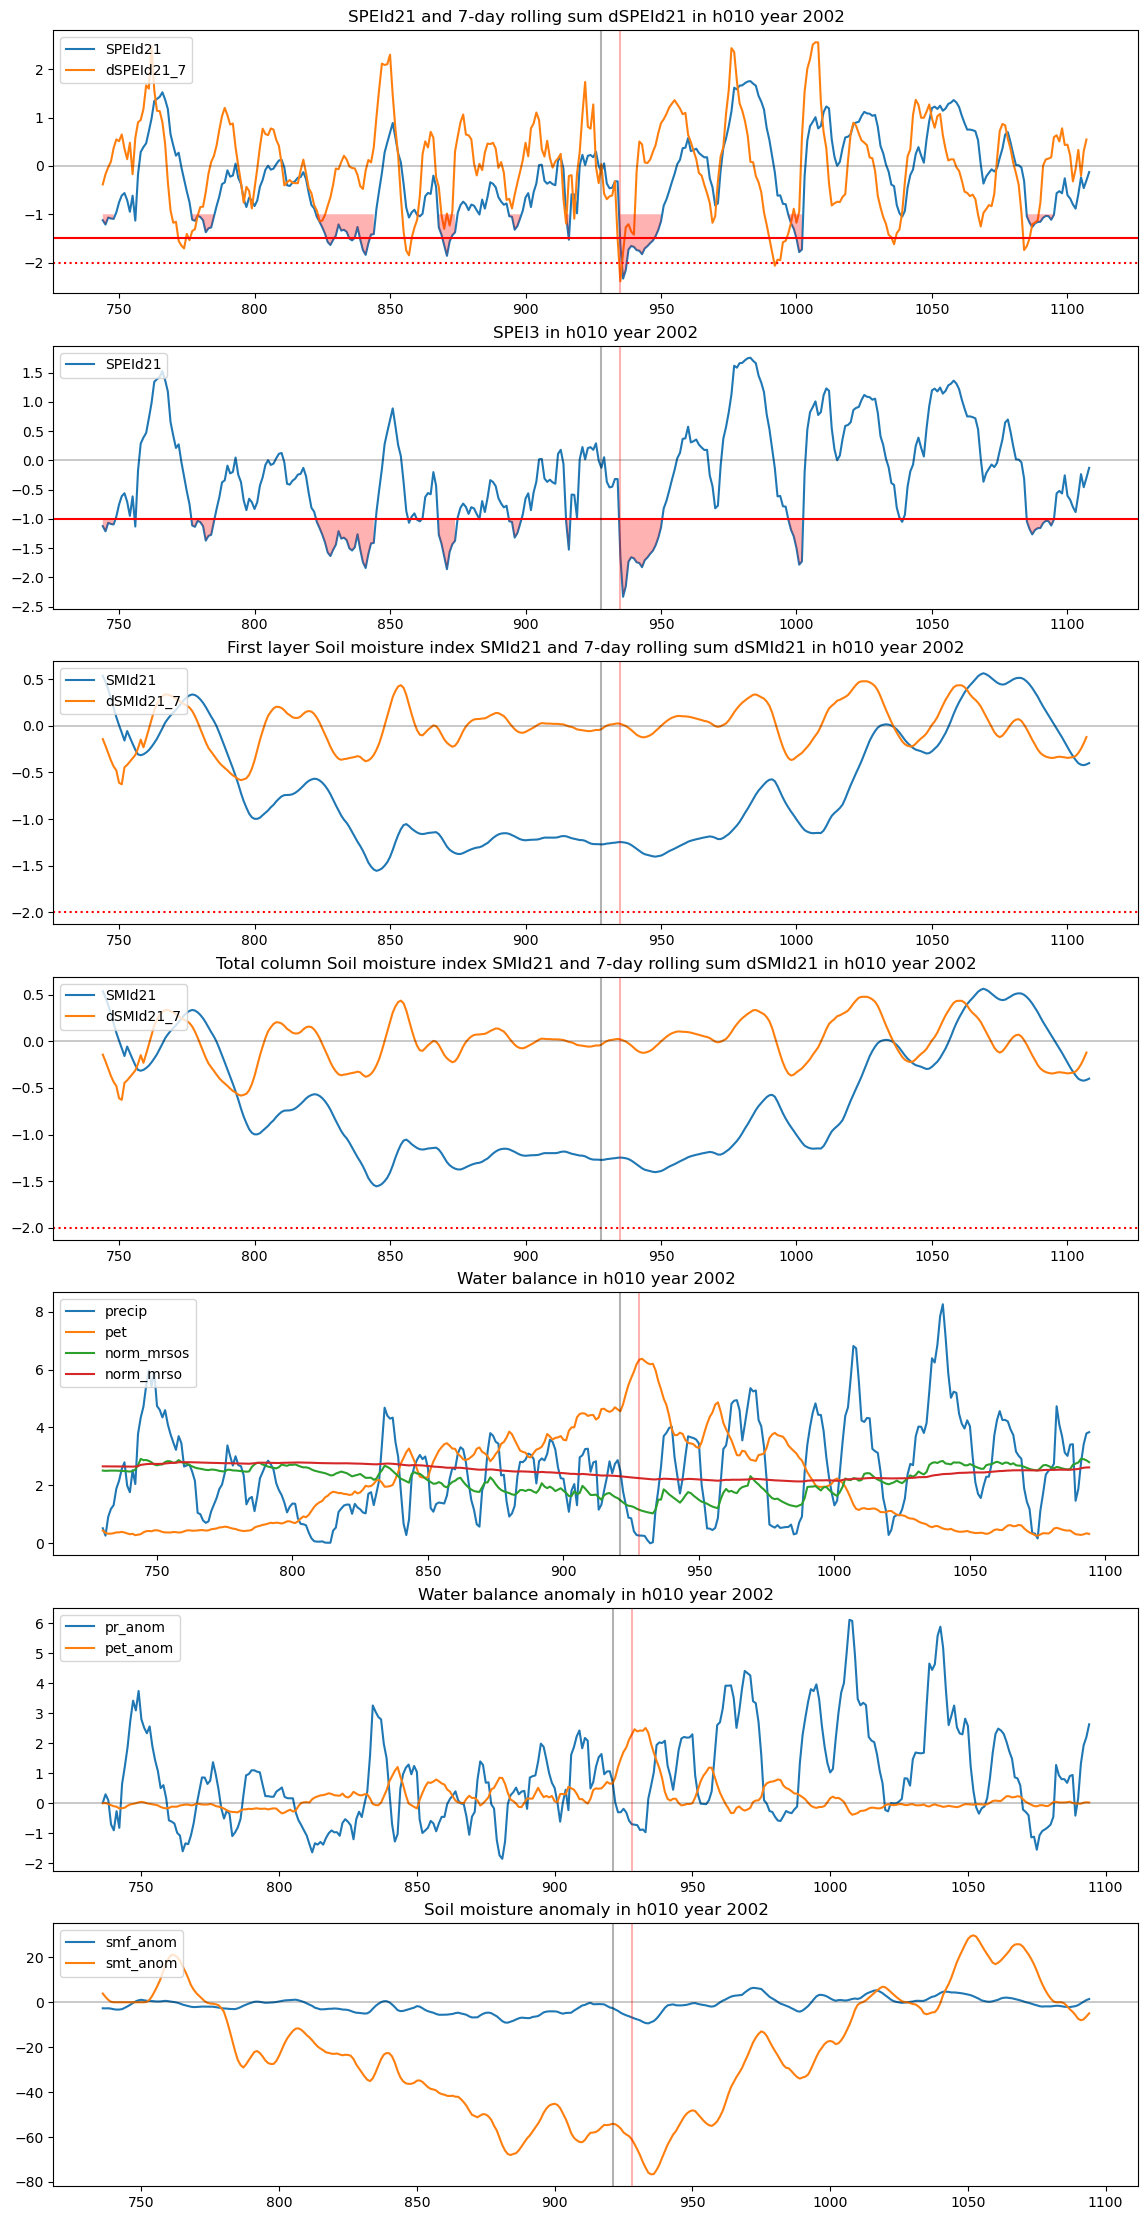

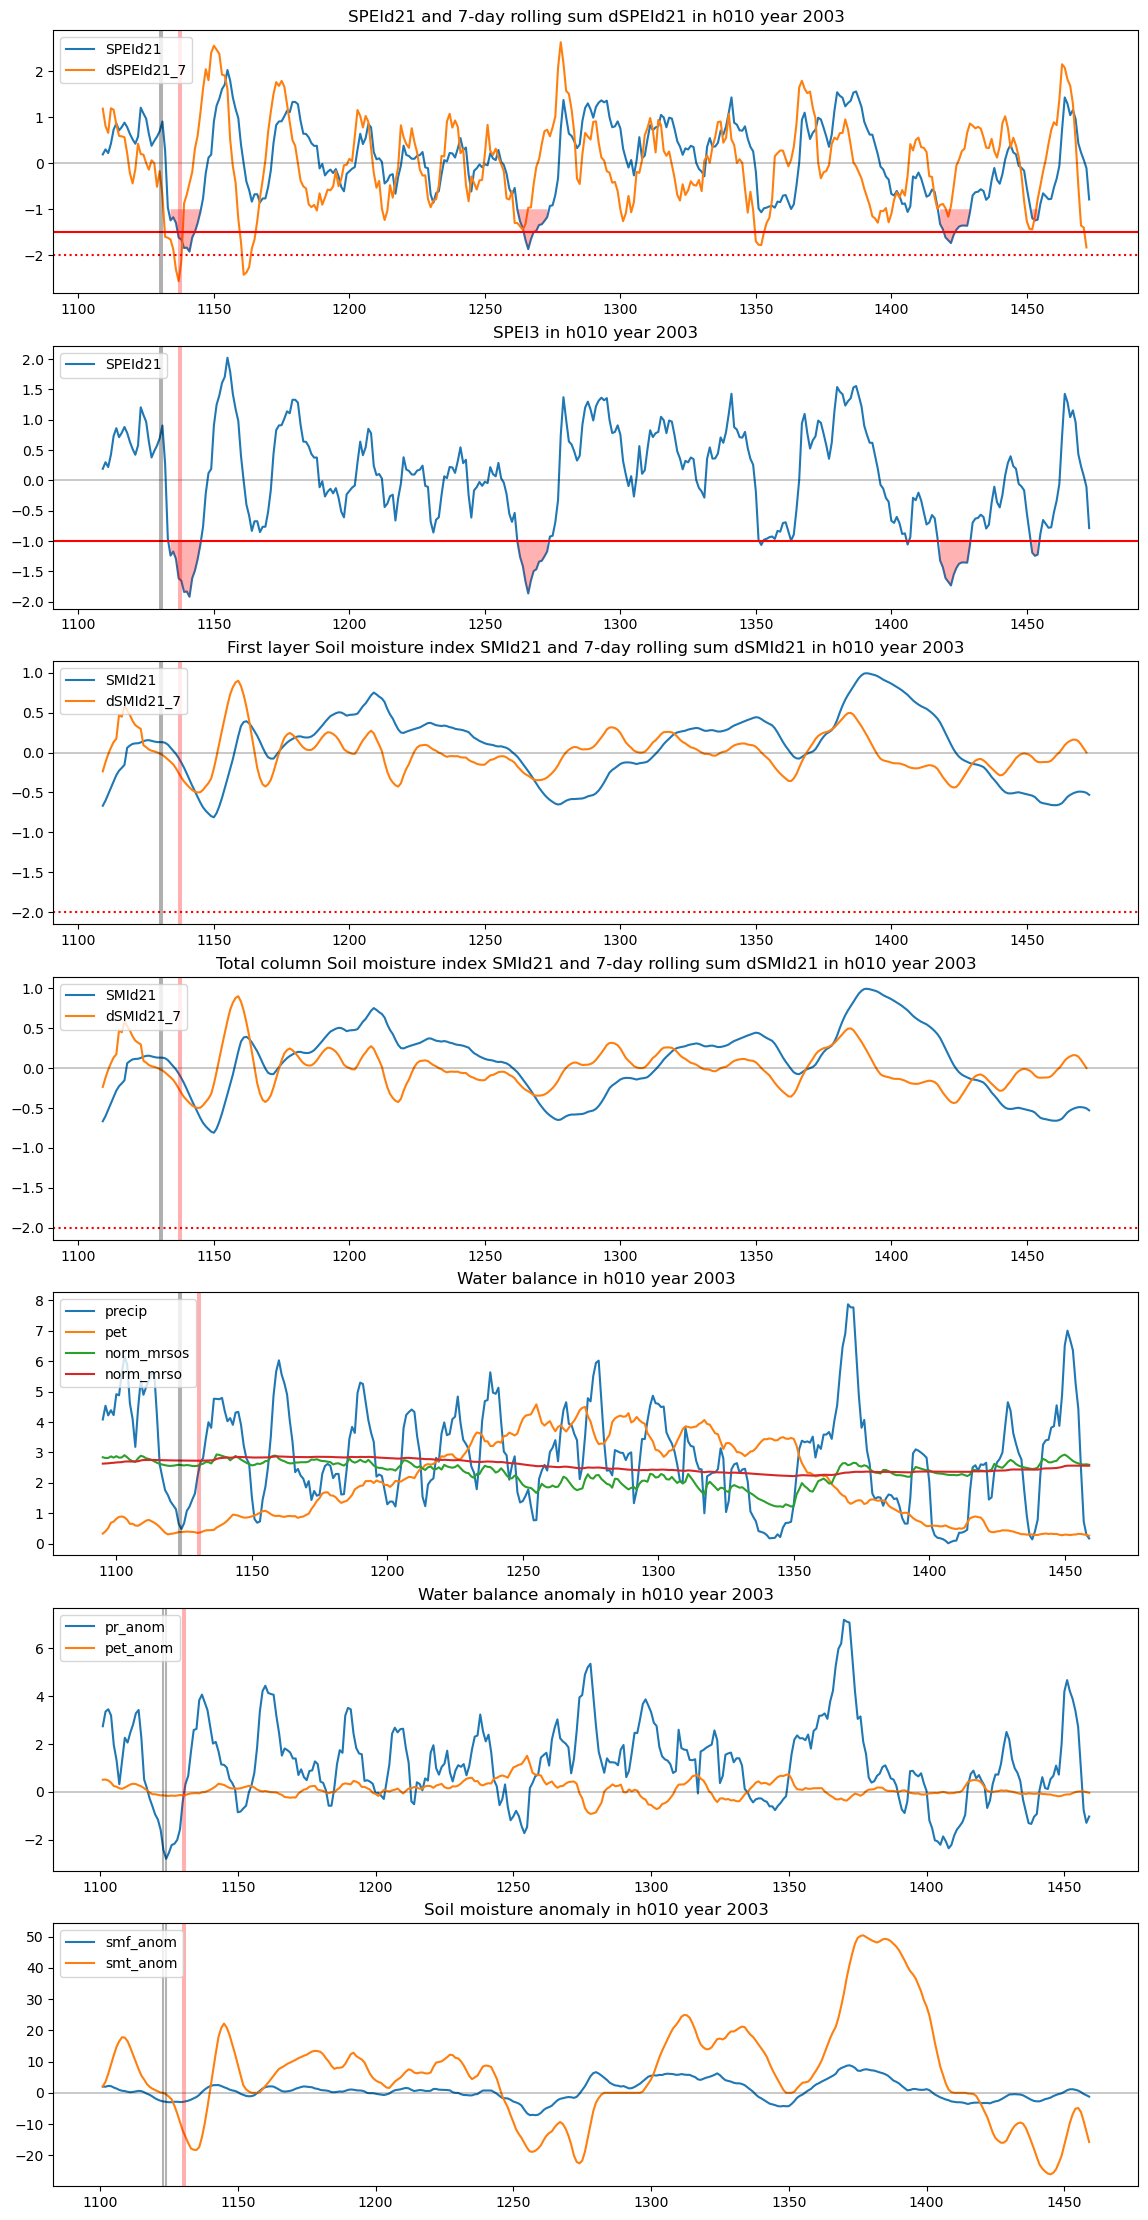

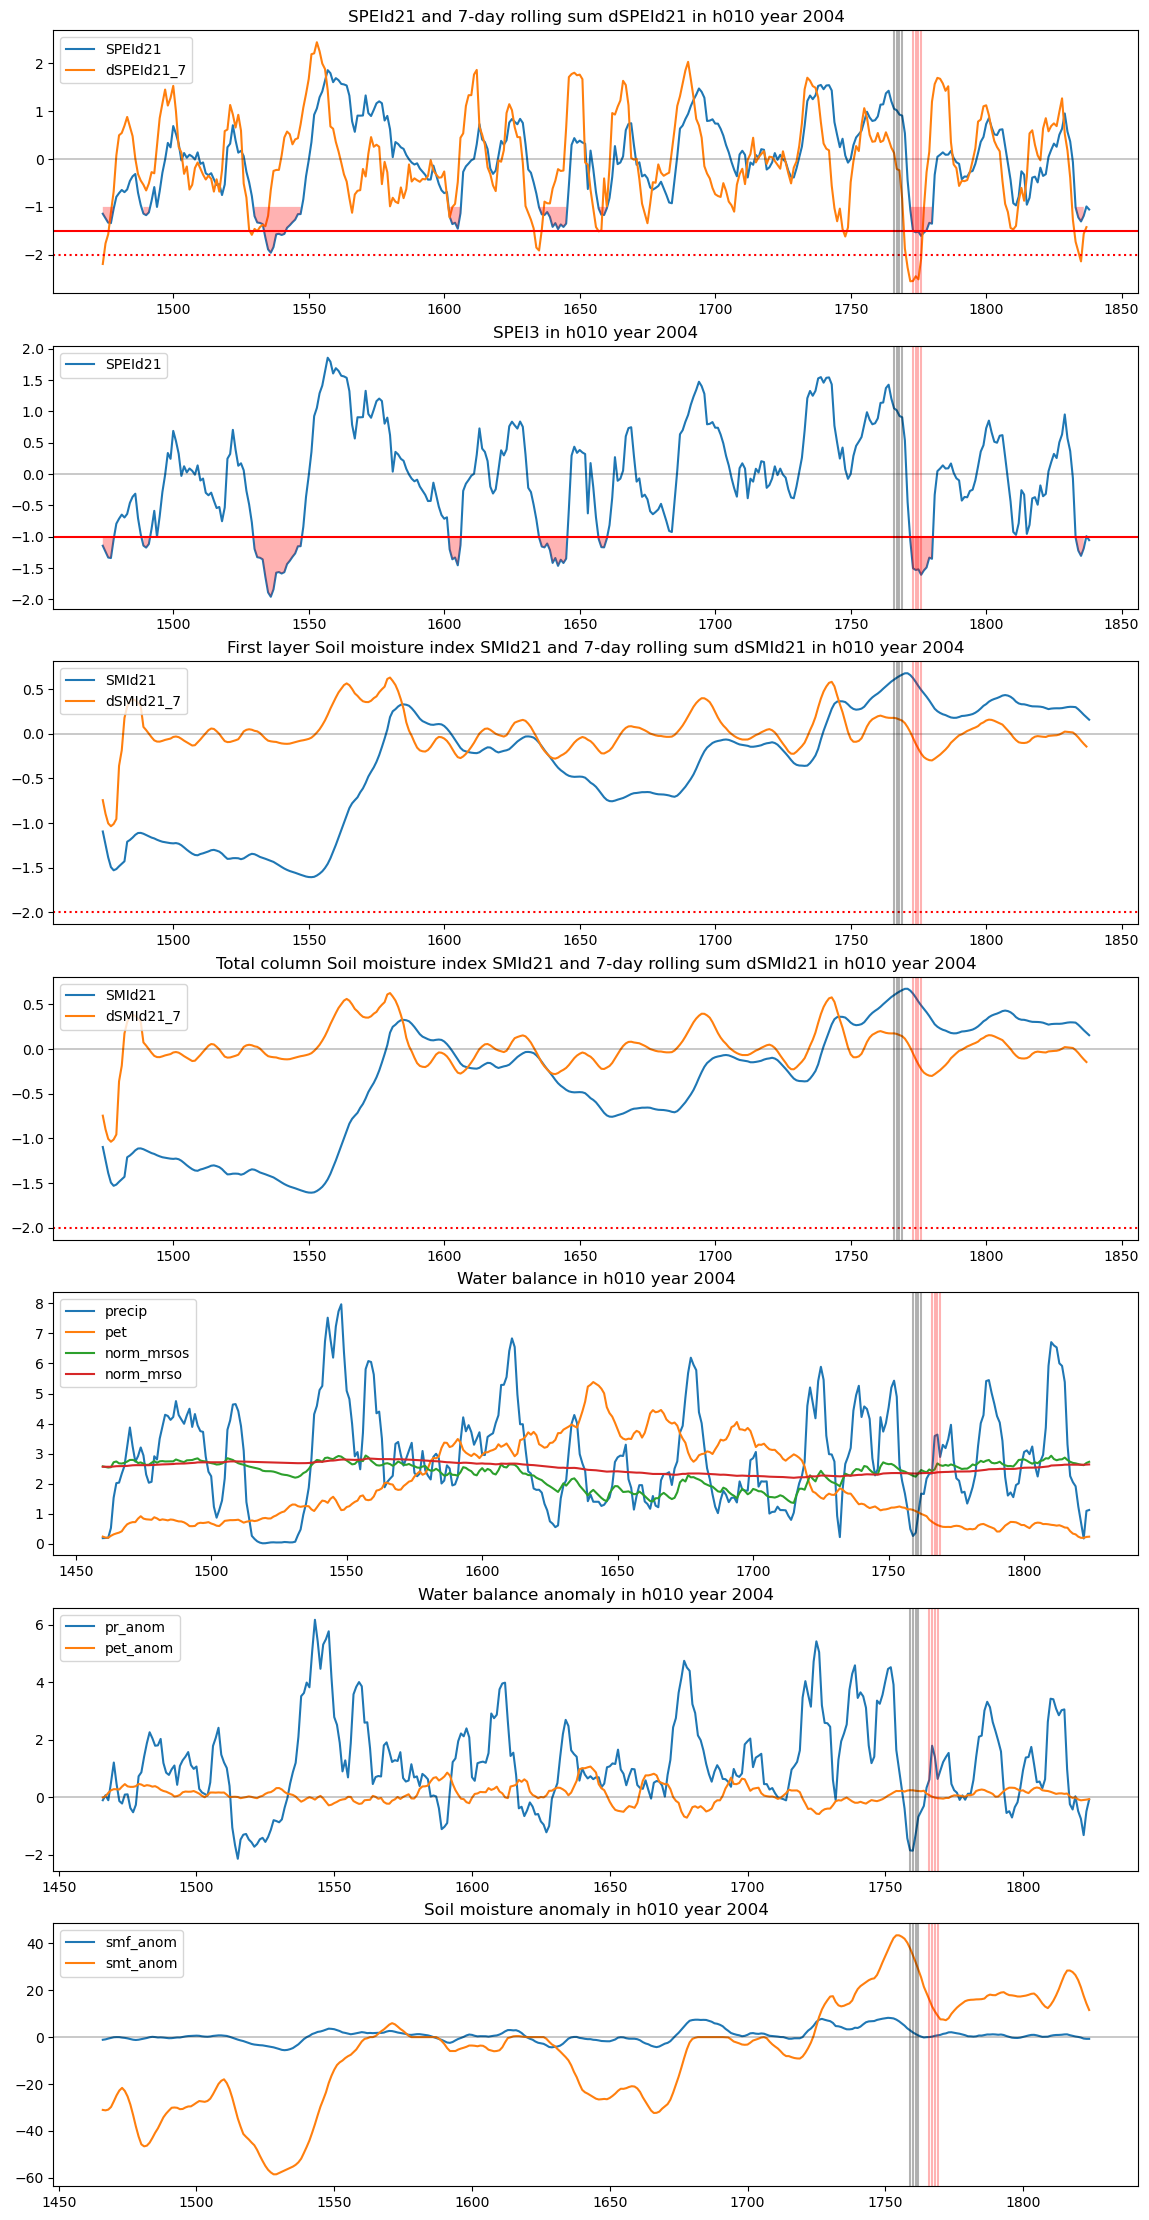

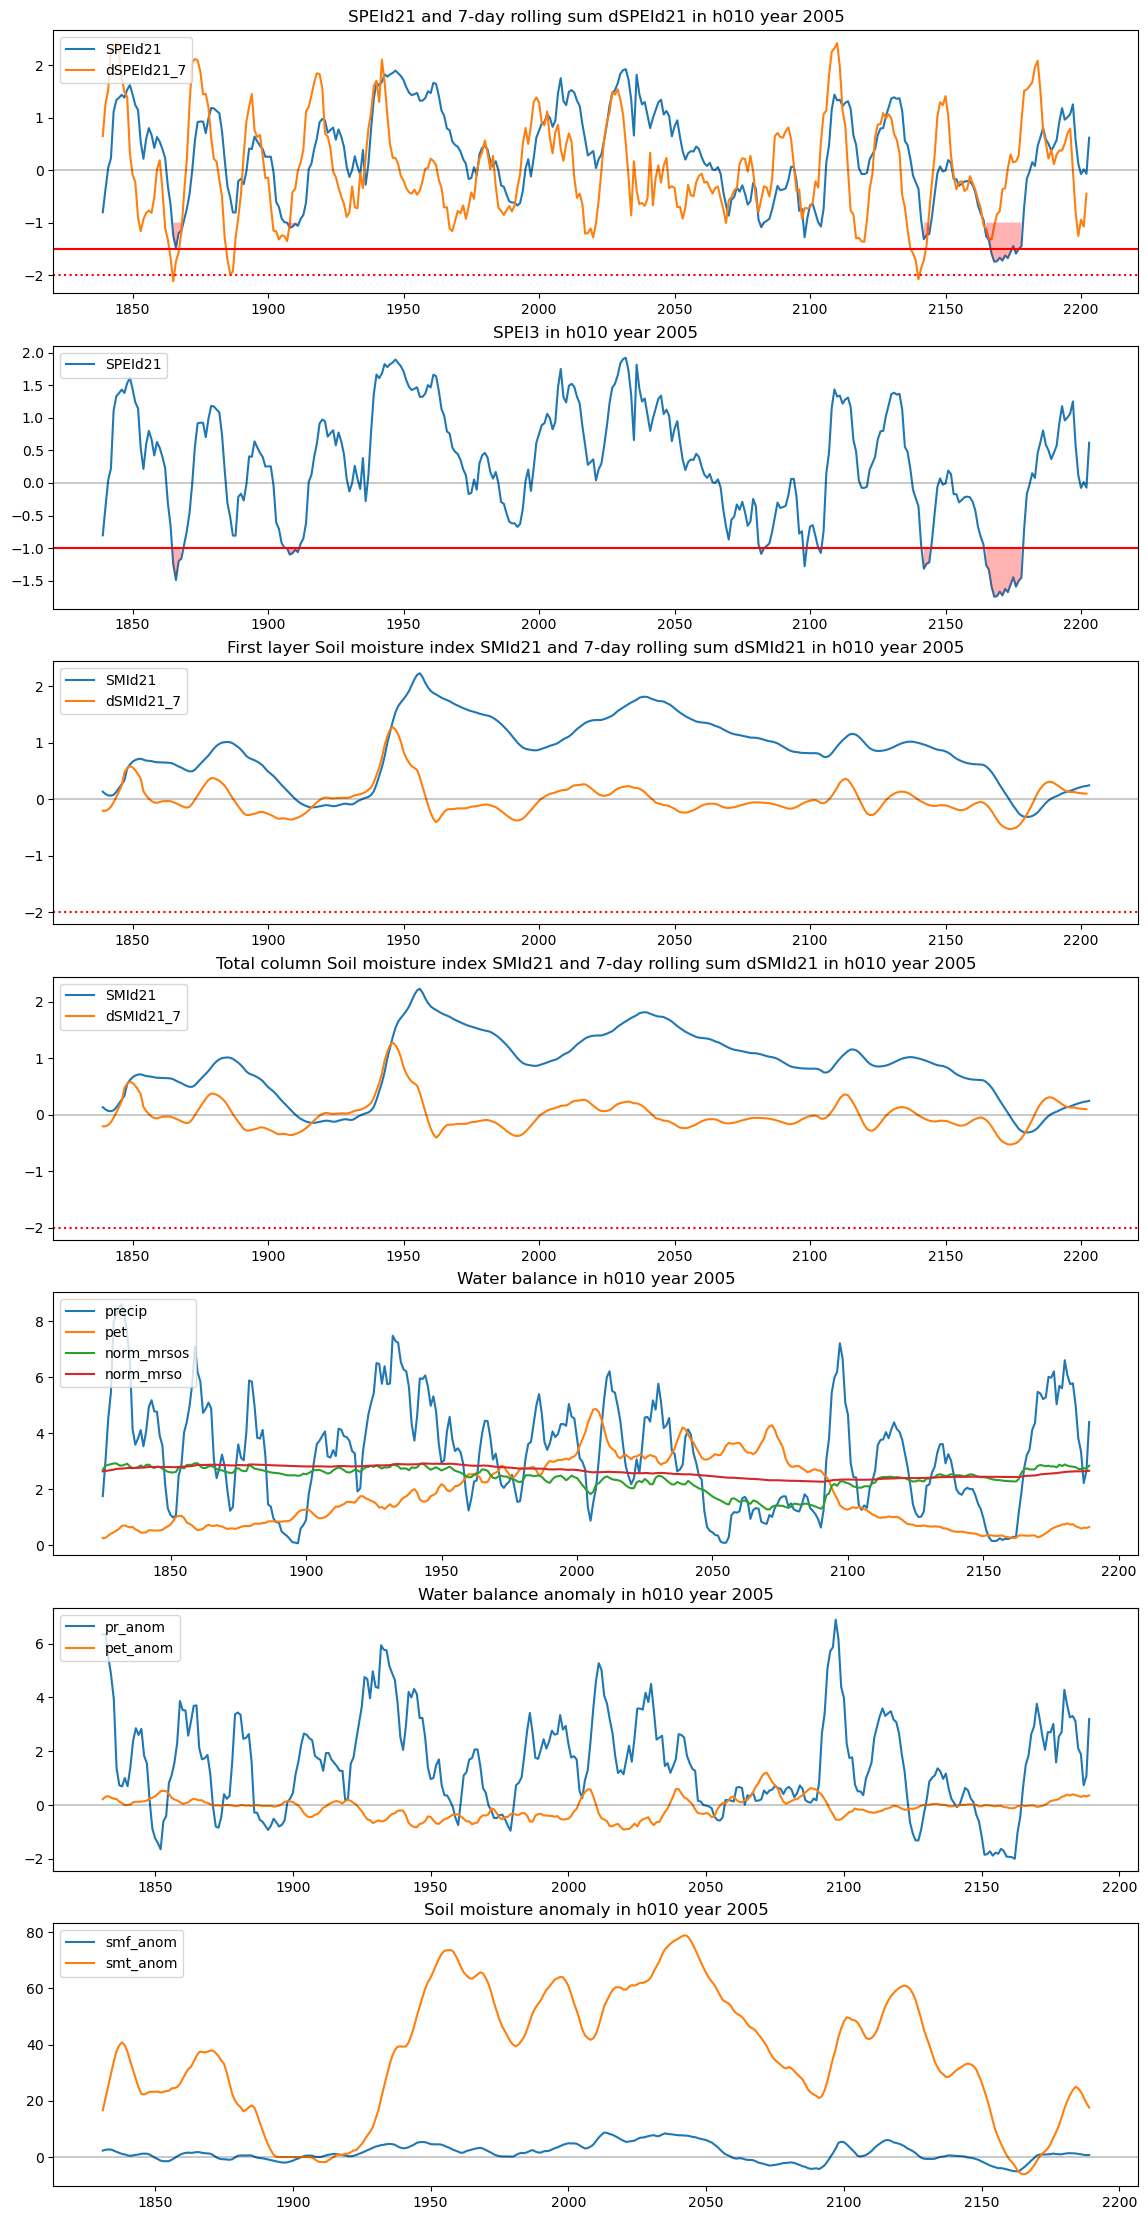

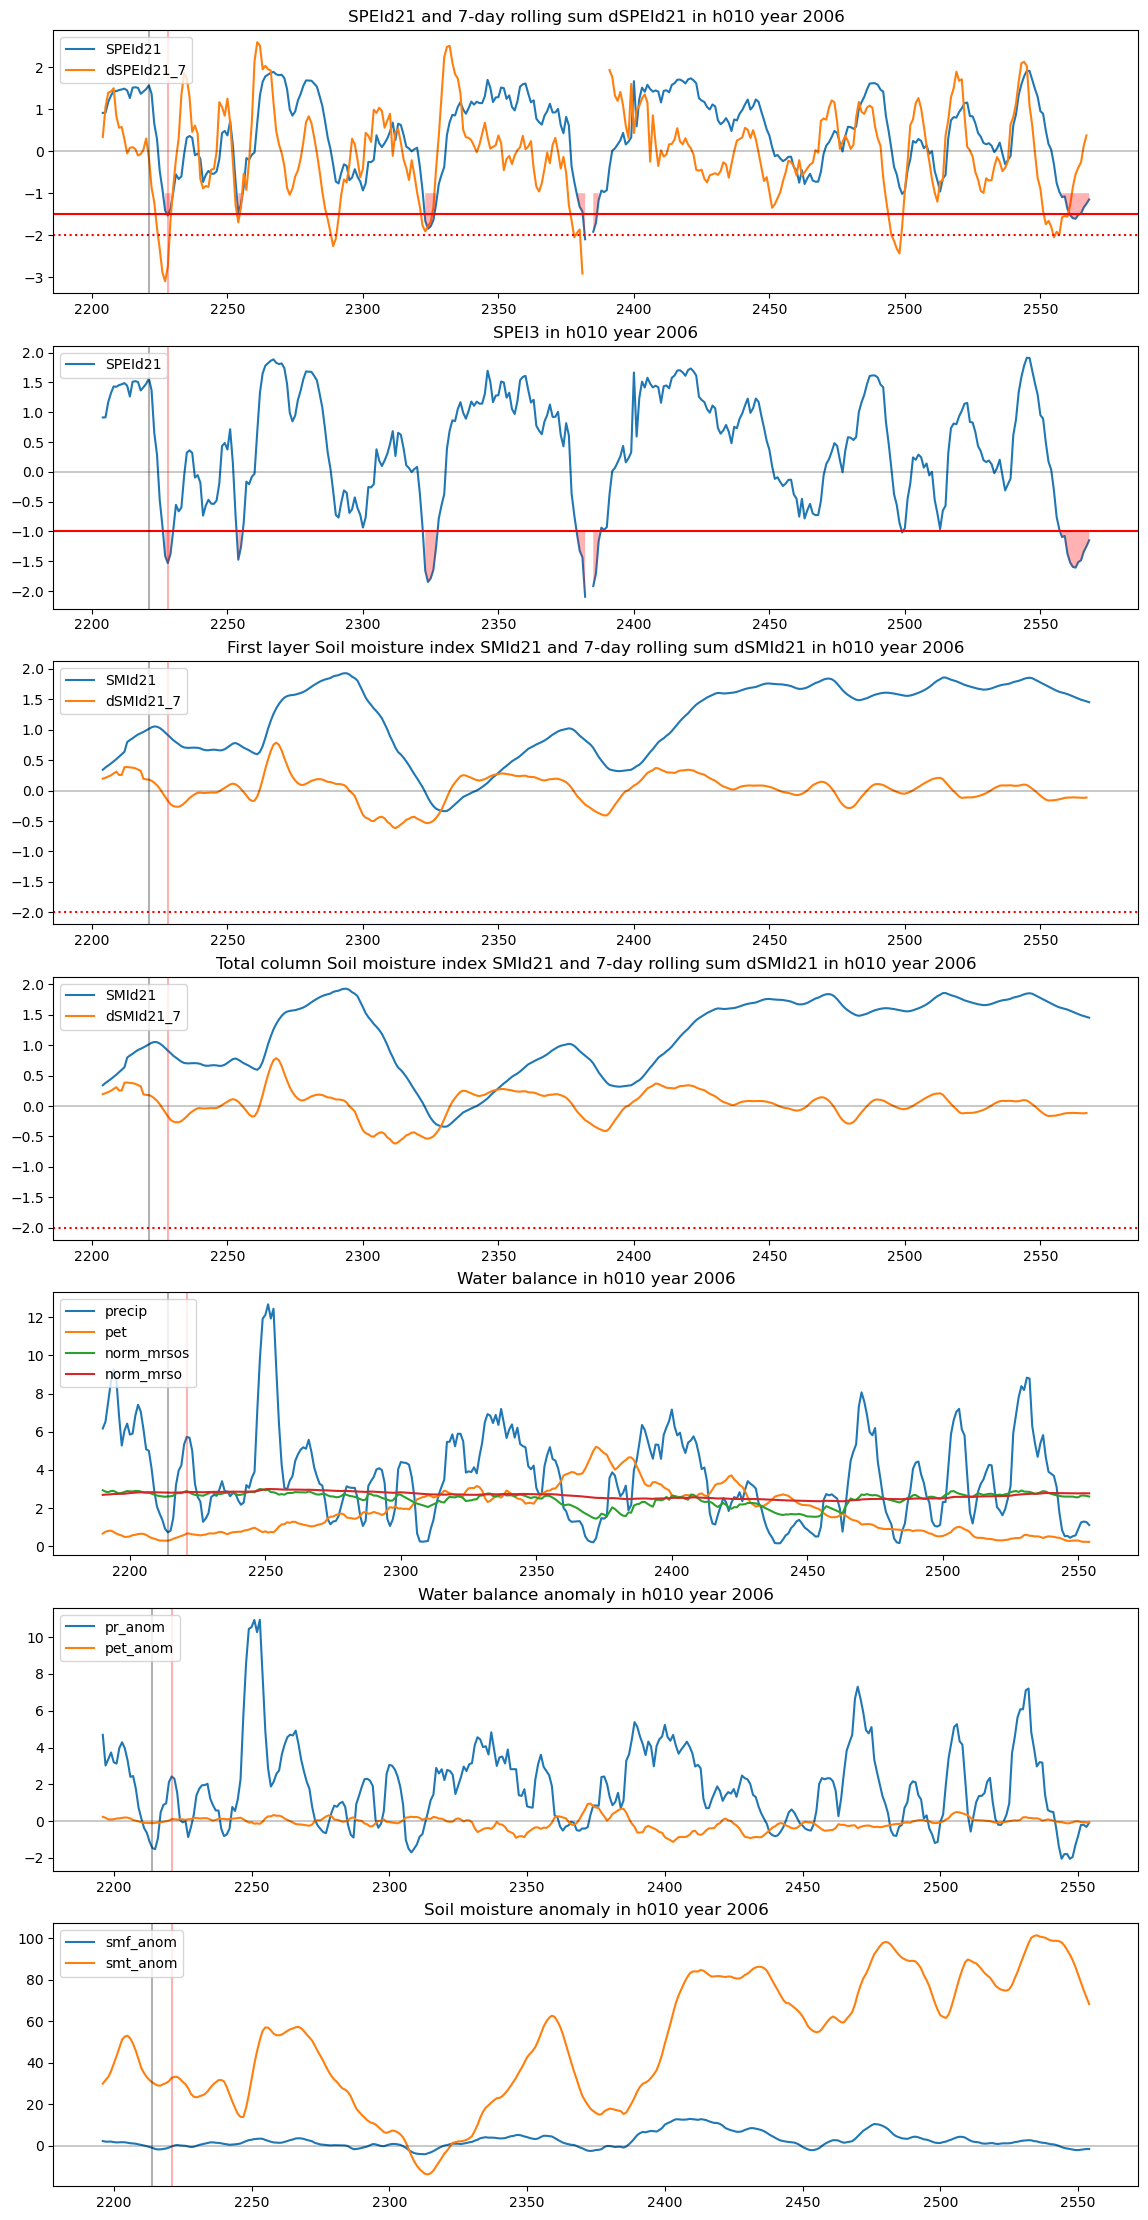

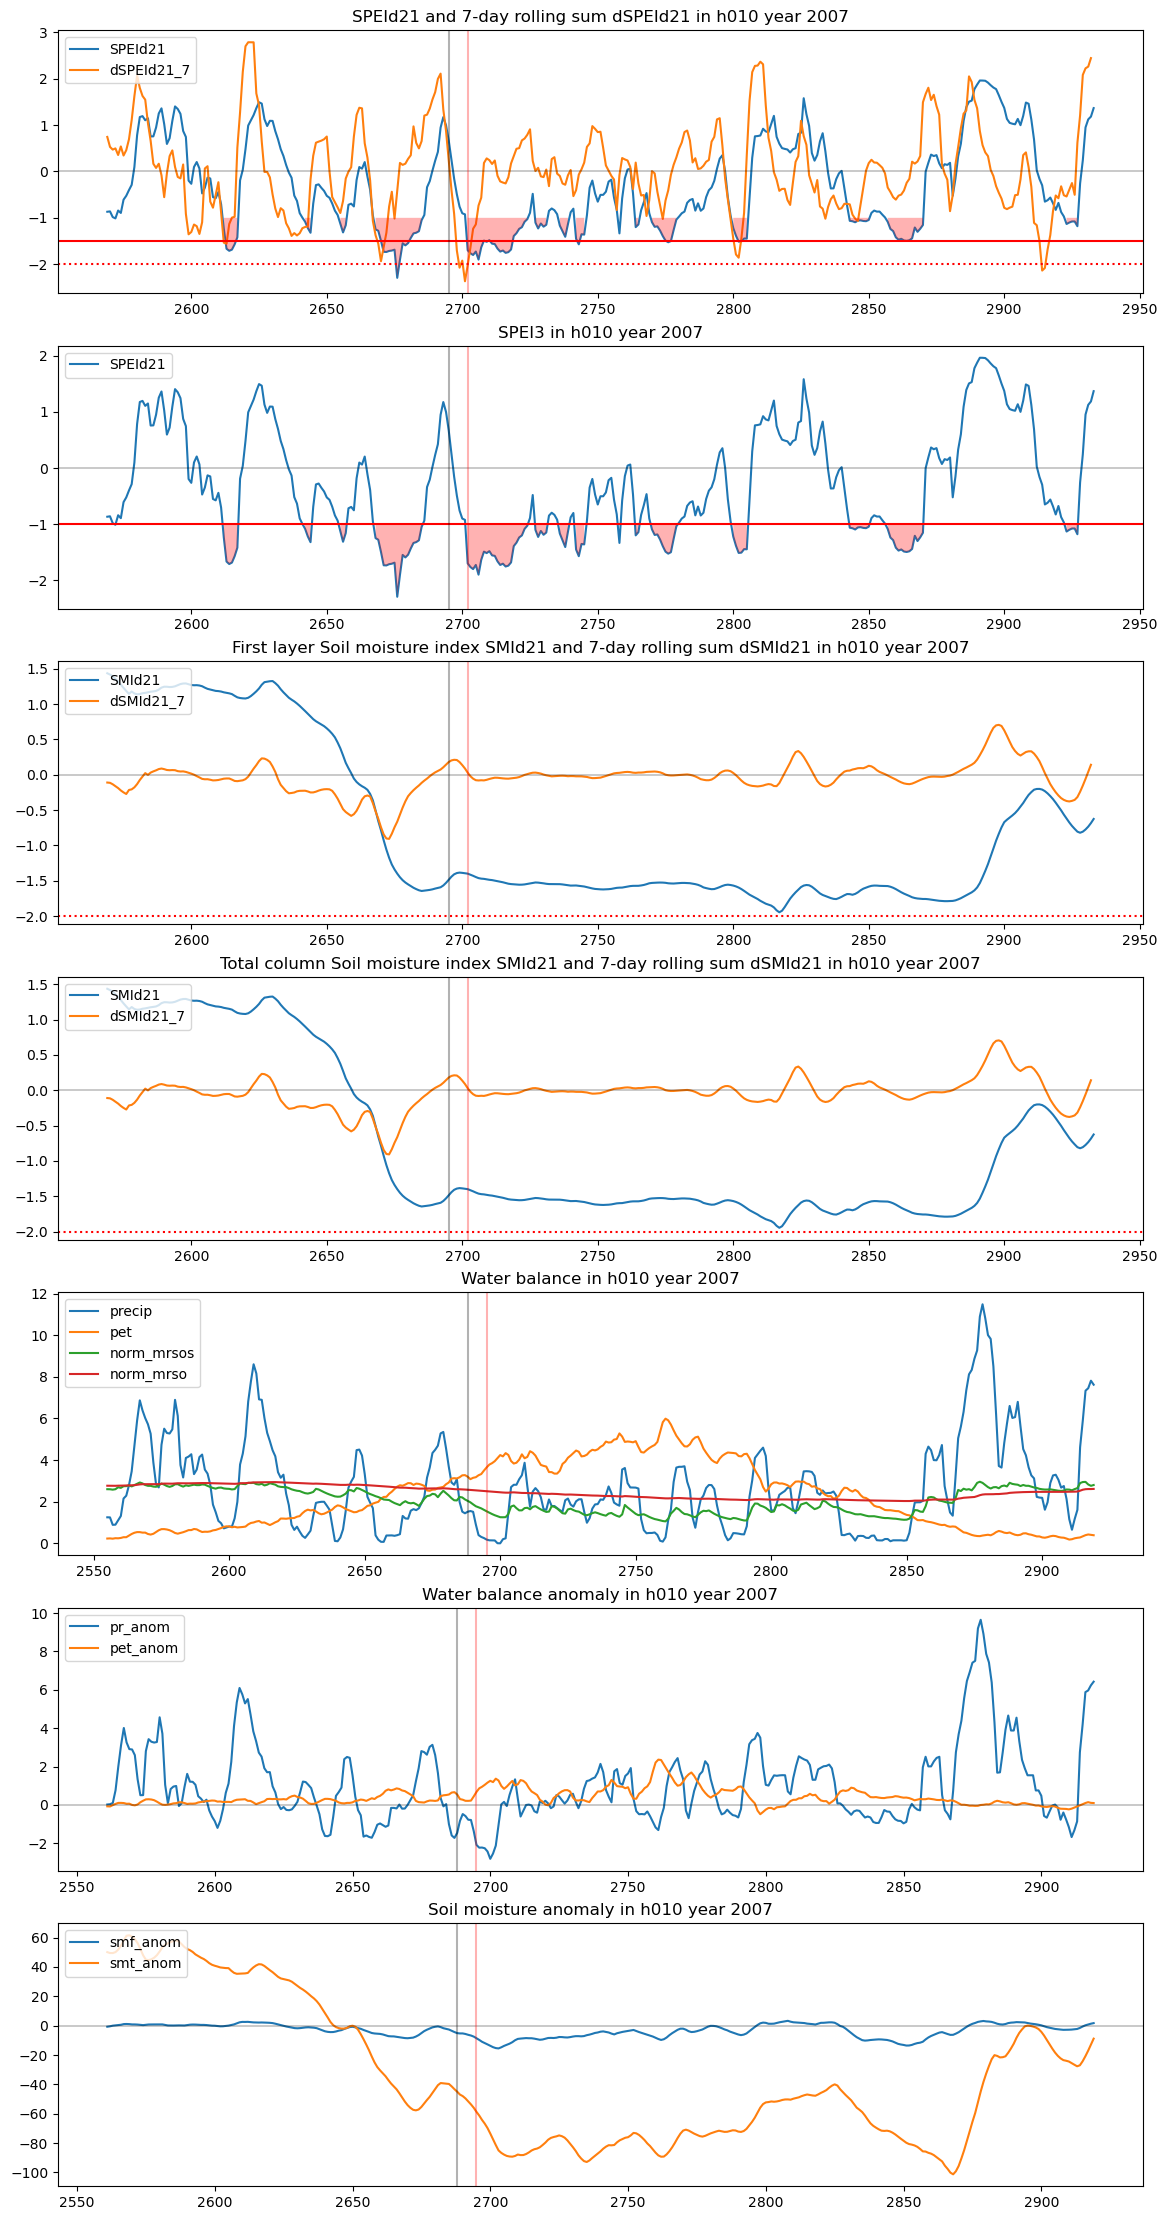

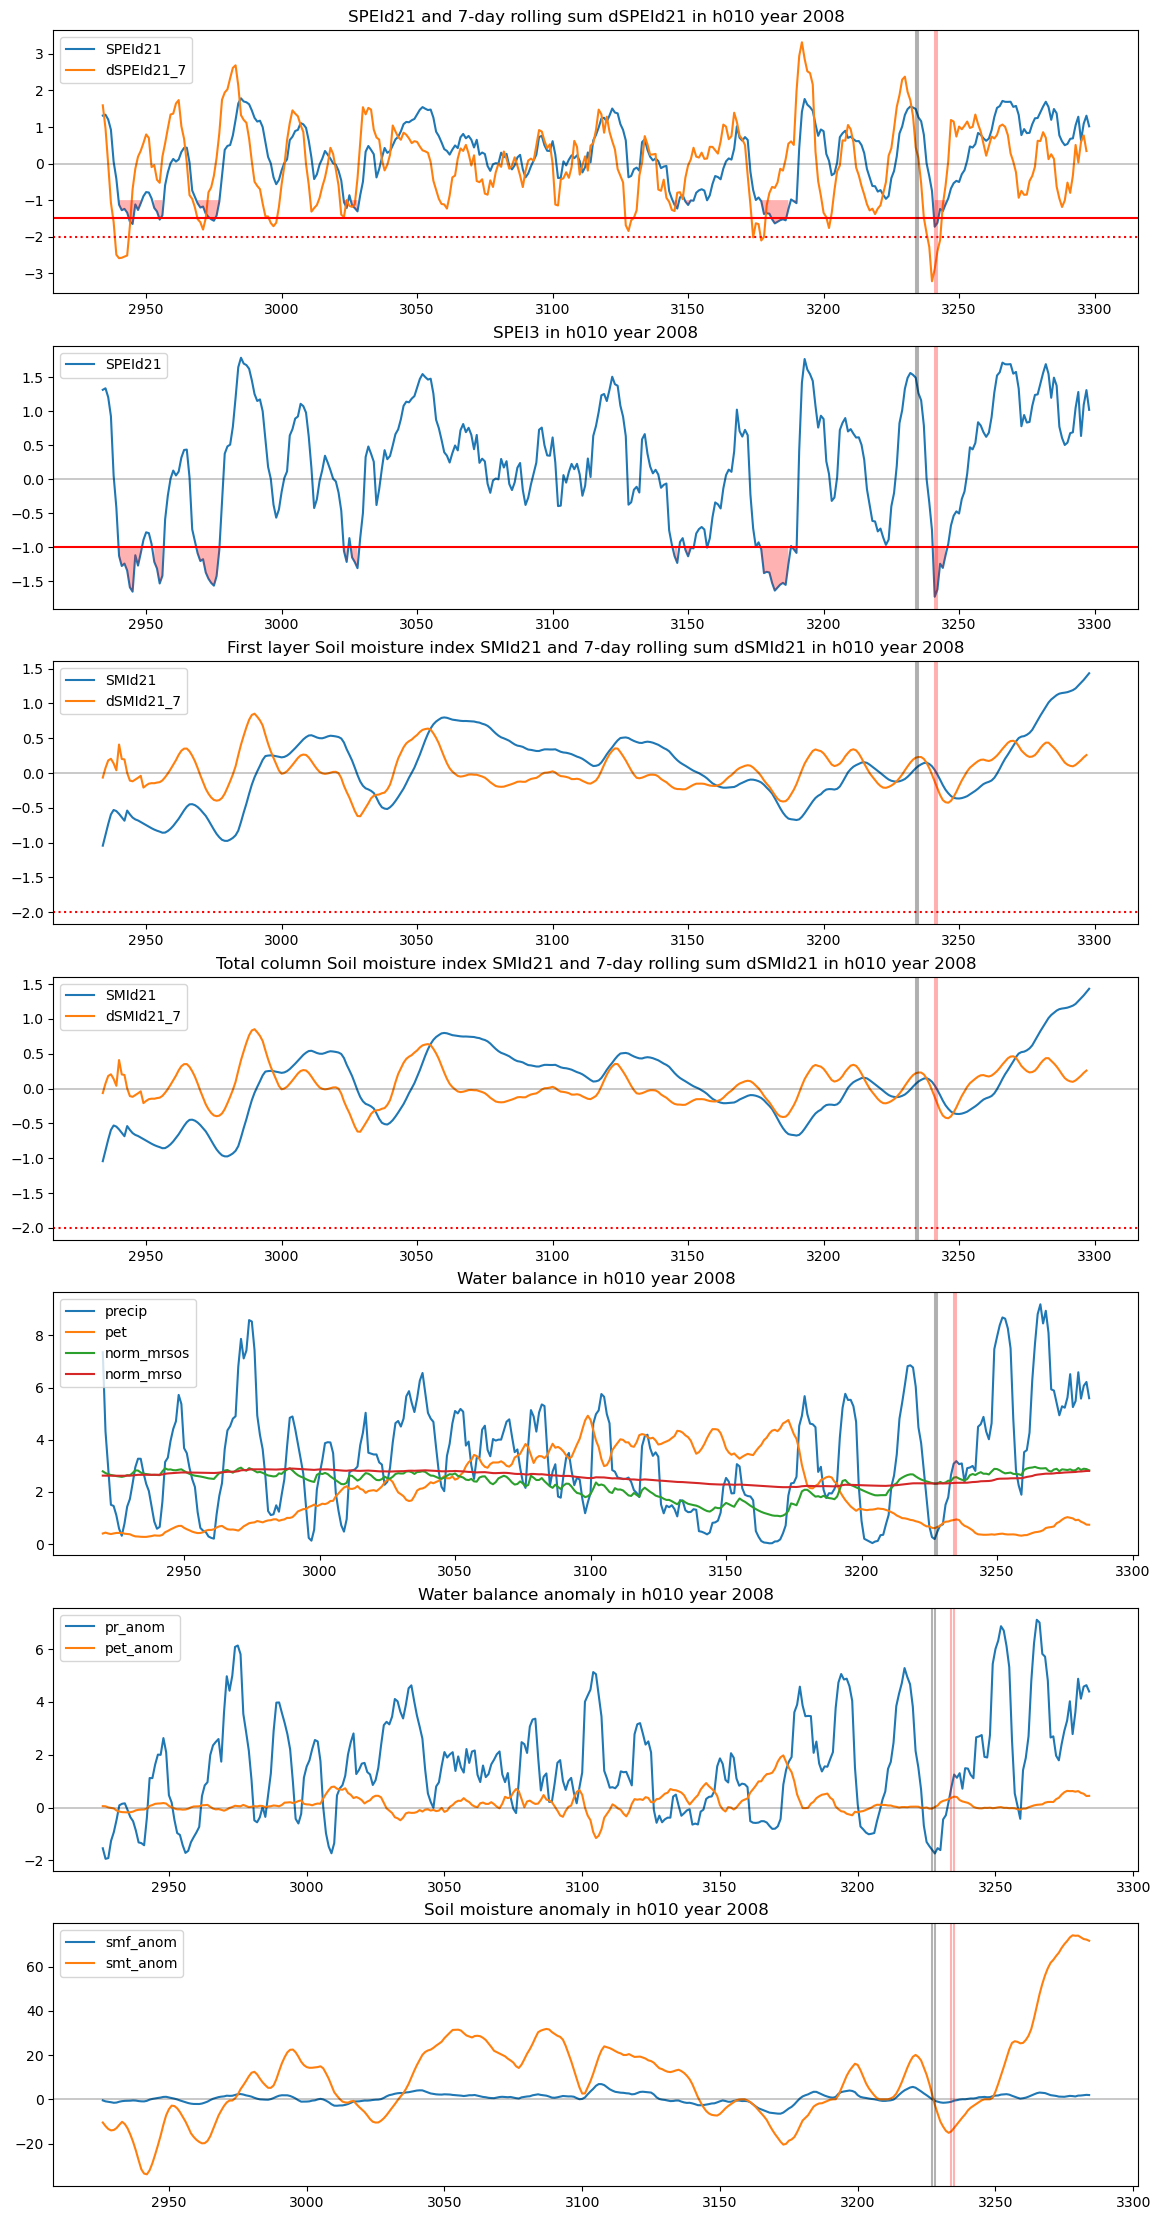

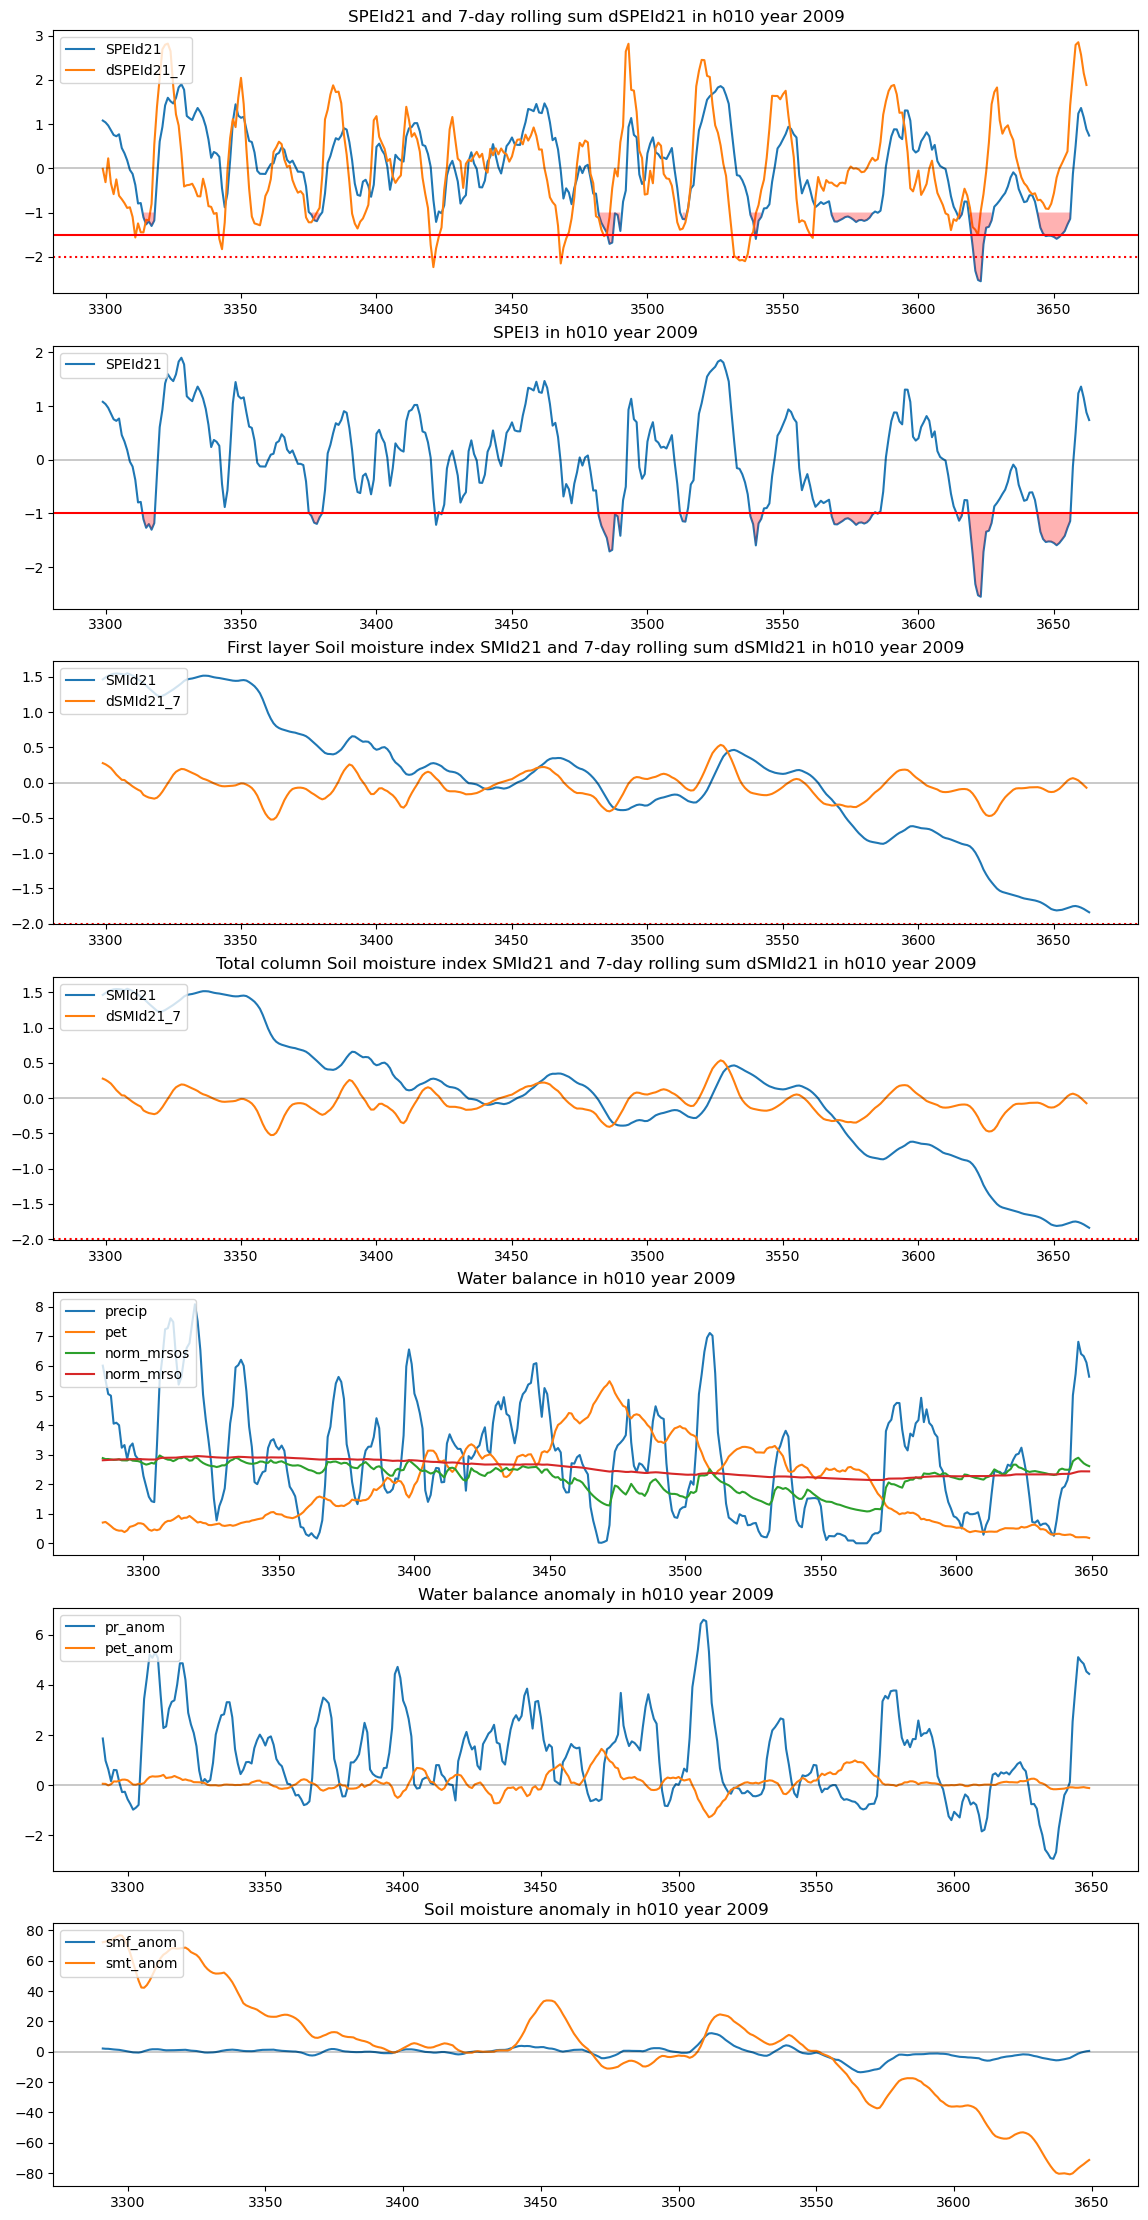

In [47]:
for year in np.arange(0,10,1):
    fig,[ax1, ax0, ax2,ax5, ax3, ax4, ax6] = plt.subplots(7, 1,figsize=(14,28))
    
    start = 365*year
    end   = 365 + 365*year
    
    xaxis_i = xaxis = range(14,np.shape(dayTSpet)[0]+14)
    xaxis_t = xaxis = range(0,np.shape(dayTSpet)[0])
    
    da_pr_anom = pd.Series(np.array((dayTSpr*60*60*24)[start:end]) - np.array(da_pr_ann[0][1])).rolling(window=window).mean()
    da_pet_anom = pd.Series(np.array((dayTSpet)[start:end]) - np.array(da_pet_ann[0][1])).rolling(window=window).mean()
    da_smf_anom =  pd.Series(np.array((tsf)[start:end]) - np.array(da_smf_ann[0][1])).rolling(window=window).mean()
    da_smt_anom =  pd.Series(np.array((tst)[start:end]) - np.array(da_smt_ann[0][1])).rolling(window=window).mean()
    


    ax1.plot(xaxis_i[start:end], SPEI_day[start:end], label=f'SPEId{timescale}')
    ax1.plot(xaxis_i[start:end-1], dSPEI14_sum_7[start:end-1], label=f'dSPEId{timescale}_7')
    ax1.axhline(y=-1.5, color='r', linestyle='-')
    ax1.fill_between(xaxis_i[start:end],-1,SPEI_day[start:end],where = (SPEI_day[start:end] <= -1), color='r',alpha=0.3,linewidth=0,zorder=5)
    ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.3)
    ax1.axhline(y=-2, color='r', linestyle=':')
    for i in range(start,end-1,1):
        if dSPEI14_sum_7[i] < -2 and SPEI_day[i] <= -1.5:
            #print(SPEI_day[i].values)
            ax1.axvline(x=i+14, color='r', linestyle='-',alpha=0.3,)
            ax1.axvline(x=i+7, color='k', linestyle='-',alpha=0.3,)
    
    ax1.legend(loc='upper left')
    ax1.set_title(f'SPEId{timescale} and 7-day rolling sum dSPEId{timescale} in h010 year 200{year}')   

    ax0.plot(xaxis_i[start:end], SPEI3[start:end], label=f'SPEId{timescale}')
    # ax1.plot(xaxis_i[start:end-1], dSPEI14_sum_7[start:end-1], label=f'dSPEId{timescale}_7')
    ax0.axhline(y=-1, color='r', linestyle='-')
    ax0.fill_between(xaxis_i[start:end],-1,SPEI3[start:end],where = (SPEI3[start:end] <= -1), color='r',alpha=0.3,linewidth=0,zorder=5)
    ax0.axhline(y=0, color='k', linestyle='-', linewidth=0.3)
    # ax1.axhline(y=-2, color='r', linestyle=':')
    for i in range(start,end-1,1):
        if dSPEI14_sum_7[i] < -2 and SPEI_day[i] <= -1.5:
            #print(SPEI_day[i].values)
            ax0.axvline(x=i+14, color='r', linestyle='-',alpha=0.3,)
            ax0.axvline(x=i+7, color='k', linestyle='-',alpha=0.3,)
    
    ax0.legend(loc='upper left')
    ax0.set_title(f'SPEI3 in h010 year 200{year}') 
    
    
    norm_tsf = tsf*3/tsf.max()
    # ax2.plot(xaxis_t[start:end], norm_tsf[start:end], label='norm_mrsos')
    ax2.plot(xaxis_i[start:end], SMIF_day[start:end], label=f'SMId{timescale}')
    ax2.plot(xaxis_i[start:end-1], dSMIF14_sum_7[start:end-1], label=f'dSMId{timescale}_7')
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.3)
    ax2.axhline(y=-2, color='r', linestyle=':')
    for i in range(start,end-1,1):
        if dSPEI14_sum_7[i] < -2 and SPEI_day[i] <= -1.5:
            #print(SPEI_day[i].values)
            ax2.axvline(x=i+14, color='r', linestyle='-',alpha=0.3,)
            ax2.axvline(x=i+7, color='k', linestyle='-',alpha=0.3,)
            
    ax2.legend(loc='upper left')
    ax2.set_title(f'First layer Soil moisture index SMId{timescale} and 7-day rolling sum dSMId{timescale} in h010 year 200{year}')

    norm_tst = tst*3/tst.max()
    # ax5.plot(xaxis_t[start:end], norm_tst[start:end], label='norm_mrsos')
    ax5.plot(xaxis_i[start:end], SMIT_day[start:end], label=f'SMId{timescale}')
    ax5.plot(xaxis_i[start:end-1], dSMIT14_sum_7[start:end-1], label=f'dSMId{timescale}_7')
    ax5.axhline(y=0, color='k', linestyle='-', linewidth=0.3)
    ax5.axhline(y=-2, color='r', linestyle=':')
    for i in range(start,end-1,1):
        if dSPEI14_sum_7[i] < -2 and SPEI_day[i] <= -1.5:
            #print(SPEI_day[i].values)
            ax5.axvline(x=i+14, color='r', linestyle='-',alpha=0.3,)
            ax5.axvline(x=i+7, color='k', linestyle='-',alpha=0.3,)
            
    ax5.legend(loc='upper left')
    ax5.set_title(f'Total column Soil moisture index SMId{timescale} and 7-day rolling sum dSMId{timescale} in h010 year 200{year}')
    
    

    ax3.plot(xaxis_t[start:end], pr_rol_mean[start:end], label='precip')
    ax3.plot(xaxis_t[start:end], pet_rol_mean[start:end], label='pet')
    ax3.plot(xaxis_t[start:end], (norm_tsf)[start:end], label='norm_mrsos')
    ax3.plot(xaxis_t[start:end], (norm_tst)[start:end], label='norm_mrso')
    for i in range(start,end-1,1):
        if dSPEI14_sum_7[i] < -2 and SPEI_day[i] <= -1.5:
            #print(SPEI_day[i].values)
            ax3.axvline(x=i+7, color='r', linestyle='-',alpha=0.3,)
            ax3.axvline(x=i, color='k', linestyle='-',alpha=0.3,)
    ax3.legend(loc='upper left')
    ax3.set_title(f'Water balance in h010 year 200{year}')
    
    ax4.plot(xaxis_t[start:end], da_pr_anom, label='pr_anom')
    ax4.plot(xaxis_t[start:end], da_pet_anom, label='pet_anom')
    # ax4.plot(xaxis_t[start:end], da_smf_anom, label='smf_anom')
    # ax4.plot(xaxis_t[start:end], da_smt_anom, label='smt_anom')
    ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.3)
    for i in range(start,end-1,1):
        if dSPEI14_sum_7[i] < -2 and SPEI_day[i] <= -1.5:
            #print(SPEI_day[i].values)
            ax4.axvline(x=i+7, color='r', linestyle='-',alpha=0.3,)
            ax4.axvline(x=i, color='k', linestyle='-',alpha=0.3,)
    ax4.legend(loc='upper left')
    ax4.set_title(f'Water balance anomaly in h010 year 200{year}')
    
    

    ax6.plot(xaxis_t[start:end], da_smf_anom, label='smf_anom')
    ax6.plot(xaxis_t[start:end], da_smt_anom, label='smt_anom')
    ax6.axhline(y=0, color='k', linestyle='-', linewidth=0.3)
    for i in range(start,end-1,1):
        if dSPEI14_sum_7[i] < -2 and SPEI_day[i] <= -1.5:
            #print(SPEI_day[i].values)
            ax6.axvline(x=i+7, color='r', linestyle='-',alpha=0.3,)
            ax6.axvline(x=i, color='k', linestyle='-',alpha=0.3,)
    ax6.legend(loc='upper left')
    ax6.set_title(f'Soil moisture anomaly in h010 year 200{year}')
    
    plt.savefig(f'plots/definitie/dSPEId{timescale}/WB_SPEId{timescale}_{year}.png')
    

Text(0.5, 1.0, 'dSMId14: 7-day rolling sum 10 jaar')

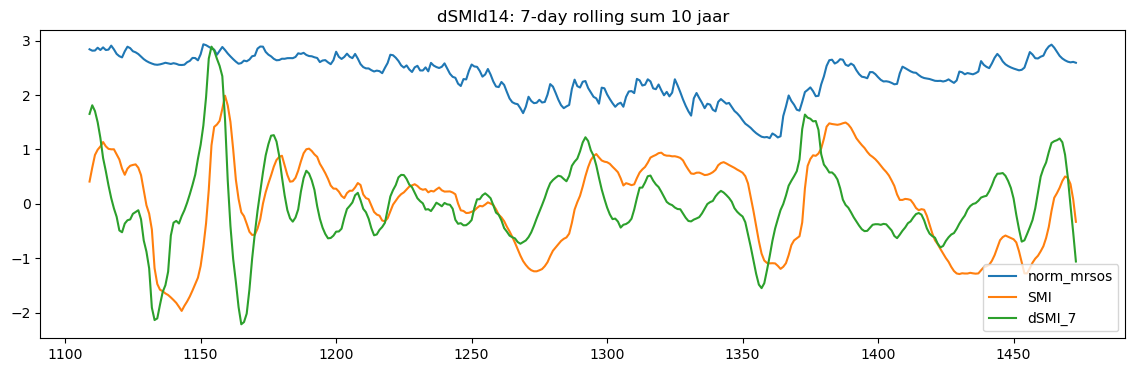

In [249]:
fig,ax = plt.subplots(1, 1,figsize=(14,4))

start = 365*3
end   = 365 + 365*3

#SMII_day[start:end].plot(label='SMI')
#dSMI14_sum_7.plot(label='dSMI')





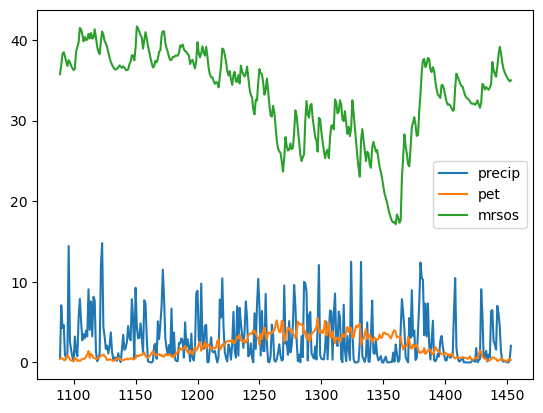

In [190]:
start = 365*3 -20
end   = 365 + 365*3 -20

da_pr = dayTSpr*60*60*24


xaxis = xaxis = range(14,np.shape(dayTSpet)[0]+14)
# xaxis = xaxis = range(0,np.shape(dayTSpet)[0])

plt.plot(xaxis[start:end], da_pr[start:end], label='precip')
plt.plot(xaxis[start:end], dayTSpet[start:end], label='pet')
plt.plot(xaxis[start:end], ts[start:end], label='mrsos')
# plt.plot(xaxis, ts, label='mrsos')
plt.legend()


In [244]:
da_pr_ann = calc_annual_cycle_quantiles((da_pr), [0.5,])
da_pet_ann = calc_annual_cycle_quantiles((dayTSpet), [0.5,])

In [252]:
start = 365*year
end   = 365 + 365*year
da_sm_ann = calc_annual_cycle_quantiles((ts), [0.5,])
da_sm_anom = np.array((ts)[start:end]) - np.array(da_sm_ann[0][1])

Text(0.5, 1.0, 'Water balance in h010 year 2003')

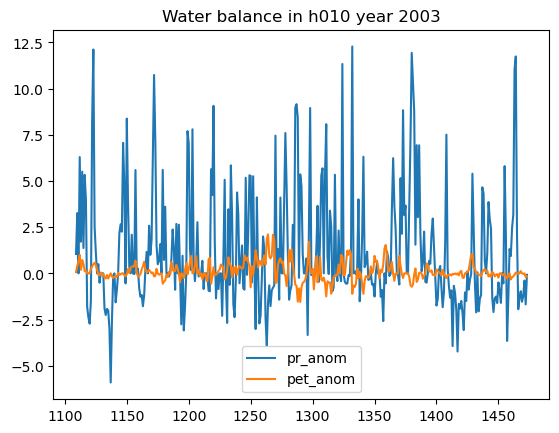

In [246]:
year=3
start = 365*year
end   = 365 + 365*year


da_pr_anom = np.array((dayTSpr*60*60*24)[start:end]) - np.array(da_pr_ann[0][1])
da_pet_anom = np.array((dayTSpet)[start:end]) - np.array(da_pet_ann[0][1])


xaxis = xaxis = range(14,np.shape(dayTSpet)[0]+14)
# xaxis = xaxis = range(0,np.shape(dayTSpet)[0])

plt.plot(xaxis[start:end], da_pr_anom[0:365], label='pr_anom')
plt.plot(xaxis[start:end], da_pet_anom[0:365], label='pet_anom')
#plt.plot(xaxis[start:end], da_pet2_anom[0][0:365], label='pet2_anom')
# plt.plot(xaxis[start:end], da_pet[start:end], label='pet')
# plt.plot(xaxis[start:end], ts[start:end], label='mrsos')
# plt.plot(xaxis, ts, label='mrsos')
plt.legend()

plt.title(f'Water balance in h010 year 200{year}')


#### Have a bunch of necessary definitions

In [9]:
def open_one_LENTIS(var, freq, timeslice, i, j, diri, plev=None):
    """
    Open one LENTIS data file from the ensemle
    """
    if timeslice == 'PD': 
        letter = 'h'
    elif timeslice == '2K': 
        letter = 's'
        
    ens_member=f'{letter}{str(i).zfill(2)}{str(j)}'
    
    file=f"{diri}/{timeslice}/{freq}/{var}/{var}_{ens_member}.nc"
    
    if plev != None:
        ds=xr.open_dataset(file).sel(plev=plev)
    else:
        ds=xr.open_dataset(file)
    
    return ds.convert_calendar('noleap'), ens_member

In [10]:
def calc_boxstat(ds, var, area='global'): 
    """
    Compute spatial weighted mean
    ds      :  xarray DataArray
    """ 
    box_seasons = ds.time.dt.season

    if hasattr(ds, 'lat'):
            weights = np.cos(ds.lat * np.pi / 180)
    elif hasattr(ds, 'latitude'):
            weights = np.cos(ds.latitude * np.pi / 180)

    if area=='global':
        if hasattr(ds, 'lat'):
            boxstat = ds[var].weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].weighted(weights).mean(dim=('latitude','longitude')) 
    elif area=='nh':
        if hasattr(ds, 'lat'): 
            boxstat = ds[var].sel(lat=slice(0,90)).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].sel(latitude=slice(0,90)).weighted(weights).mean(dim=('latitude','longitude')) 
    elif area=='europe':
        if hasattr(ds, 'lat'):
            boxstat = ds[var].sel(lat=slice(30,70),lon=slice(-10,40)).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].sel(latitude=slice(30,70),longitude=slice(-10,40)).weighted(weights).mean(dim=('latitude','longitude'))  

    # regions for Pieter Slomp
    elif area in ['rhine',]:
        path_mask = '/perm/nklm/Px_drought/' + area + '.nc'
        basin_mask = xr.open_dataset(path_mask).catchmentID[0,:,:]

        if hasattr(ds, 'lat'):
            boxstat = ds[var].where(basin_mask).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].where(basin_mask).weighted(weights).mean(dim=('latitude','longitude'))   
            
    # regions for Leonie Hemelrijk
    elif area=='LH_westEU':
        if hasattr(ds, 'lat'):
            boxstat = ds[var].sel(lat=slice(30,60),lon=slice(-30,30)).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].sel(latitude=slice(30,60),longitude=slice(-30,30)).weighted(weights).mean(dim=('latitude','longitude'))    
    elif area=='LH_rhine':
        if hasattr(ds, 'lat'):
            boxstat = ds[var].sel(lat=slice(47,55),lon=slice(2,10)).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].sel(latitude=slice(47,55),longitude=slice(2,10)).weighted(weights).mean(dim=('latitude','longitude'))

    else:
        raise ValueError('unknown area: '+area)
            
            
    return boxstat, box_seasons

In [11]:
def get_attr_info(var, freq, timeslice, diri):
    """
    
    """
    ds, ens_member = open_one_LENTIS(var, freq, timeslice, 1, 1, diri)
    
    # get global attributes
    attrs=ds.attrs
    
    # get coordinates
    time_attrs=ds.time.attrs
    lat_attrs=ds.lat.attrs
    lon_attrs=ds.lon.attrs

    # get coordinate bounds 
    time_bnds=ds.time_bnds
    lat_bnds=ds.lat_bnds
    lon_bnds=ds.lon_bnds
    
    # get part of the var attributes
    var_units=ds[var].units
    var_standard_name=ds[var].standard_name
    var_long_name=ds[var].long_name
    
    
    return attrs, time_attrs, time_bnds, var_units, var_standard_name, var_long_name

In [12]:
def calc_ens_statistics_and_to_netcdf(var, freq, timeslice, plev, diri, diro, area='global', seas='ANN', statistic='mean'):
    '''
    """Compute the annual-averaged, global weighted mean 
    for a given variable, for all ensemble members of a time slice"""
    '''
    
    # define variables of the computed quantity and its ensemble member
    ens_stat_values=[]
    ens_member_list=[]
    
    # Do the calculation
    for i in np.arange(1,16+1):
        for j in np.arange(0,9+1):
            ds, ens_member = open_one_LENTIS(var, freq, timeslice, i, j, diri, plev)
            #ds, ens_member = open_one_LENTIS(var, freq, timeslice, i, j, diri)
            boxstat,box_seasons = calc_boxstat(ds, var, area)
            seasonal_avg = calc_seasonal_avg(boxstat,box_seasons, seas)

            ens_stat_values.append(seasonal_avg)
            ens_member_list.append(ens_member)
            del ds,boxstat,seasonal_avg,ens_member

    
    # Prepare xarray.dataset to save as Netcdf file
    attrs, time_attrs, time_bnds, var_units, var_standard_name, var_long_name = get_attr_info(var,freq,timeslice, diri)
    
    # time_attrs = {'standard_name': 'time',
    #                 'long_name': 'time',
    #                 'bounds': 'time_bnds',
    #                 'axis': 'T'}
    
    time_bnds_combined, time_avg = get_avg_timebnds(var, freq, timeslice, diri, seas)
    
    ens_attrs = {'standard_name': 'ens_mem',
                 'long_name': 'Ensemble member',
                 'comment': 'Postprocessed by Laura Muntjewerf (KNMI). A time slice of KNMI-LENTIS consists of 16 ensemble member of 10 years. All simulations have a unique ensemble member label that reflects the forcing, and how the initial conditions are generated. The initial conditions have two aspects: the parent simulation from which the run is branched (macro perturbation, there are 16), and the seed relating to a particular micro-perturbation in the initial three-dimensional atmosphere temperature field (there are 10). The ensemble member label thus is a combination of: forcing (h for present-dsy/historical and s for +2K/SSP2-4.5), parent ID (number between 1 and 16), micro perturbation ID (number between 0 and 9) '}
    coords={'time': (['time'], time_avg.data, time_attrs),
            'ens': (['ens'], ens_member_list, ens_attrs)
            }
    
    var_attr = {'units': var_units, 
                        'standard_name': f'{var_standard_name}_{area}_{seas}_{statistic}',
                        'long_name': f'{statistic} {var_long_name} of {area} ({seas})'}
                    
    
    # define data with variable attributes as Xarray dataset
    ds_new = xr.Dataset(
    data_vars=dict(
        time_bnds=(["time", "bnds"], 
                     time_bnds_combined,{}),
        ens_bnds=(["ens"], 
                     ens_member_list,{}),
        var=(['ens','time'],  
                      ens_stat_values, 
                       var_attr,
    )),
    coords=coords,
    attrs=attrs,
    )
    
    # assign encoding
    # otherwise it will throw error when opening with nvciew --> (ncview: netcdf_dim_value: unknown data type (10) for dimension time) en (unknown data type (12) for dimension ens)
    ds_new.ens.encoding = {'zlib': False,
                     'shuffle': False,
                     'complevel': 0,
                     'fletcher32': False,
                     'contiguous': False,
                     'chunksizes': None,
                     'dtype': '|S1'}

    ds_new.time.encoding = {'zlib': False,
                        'shuffle': False,
                        'complevel': 0,
                        'fletcher32': False,
                        'contiguous': False,
                        'dtype': np.dtype('float64'),
                        'units': 'days since 1850-01-01 00:00:00',
                        'calendar': 'proleptic_gregorian'
                        }

    

    # create dataset
    # Save in right location
    
    if plev != None:
        filo=f'{timeslice}_ensemble_{area}_{seas}_{freq}_{var}_{plev}_mean.nc'
    else:
        filo=f'{timeslice}_ensemble_{area}_{seas}_{freq}_{var}_mean.nc'
    

    ds_new.to_netcdf(f'{diro}/{filo}', unlimited_dims='ens')
    

In [13]:
def make_waterbalance_R(ds, da_pet,da_pr, frequency):
    #copy time axes, because there are differences
    da_pet['time'] = da_pr.time
    # water balance = precip - pet
    da_wb=((da_pr*60*60*24) - da_pet)
    # convert to R timeseries
    r_wb_day = r_time_series(robjects.FloatVector(da_wb), start = robjects.IntVector([ds.time.dt.year[0].values, ds.time.dt.month[0].values]), frequency = 365)
    
    return r_wb_day


In [14]:
def first_order_deriv_rolling_sum(da, window):
    first_order_deriv_rolling_sum = pd.Series(np.diff(da)).rolling(window=window).sum()
    
    return first_order_deriv_rolling_sum

In [15]:
def calc_annual_cycle_quantiles(ds, quantiles):
    annual_cycle_spread = []
    
    for quantile in quantiles:
        annual_cycle_quantile = ds.groupby('time.dayofyear').quantile(quantile, dim='time',method='nearest')
        annual_cycle_spread.append([quantile, annual_cycle_quantile])
        
    return annual_cycle_spread
        
    

In [16]:
def calc_SPEI_daily(da_wb, scale):
    r_spei_day = r_spei_function(da_wb, scale=10, na_rm=True, distribution='log-Logistic',verbose=False)
    da_spei_day = xr.DataArray(pandas2ri.ri2py_vector(r_spei_day.rx2('fitted')))
    
    return da_spei_day